# Example notebook for the tunneling Fermions

This Notebook is based on the paper from the Jochim group [[1]](#References). In these experiments two fermions of different spins are put into a single tweezer and then coupled to a second tweezer. The paper [[1]](#References) shows experimental data on how the atom number in the second tweezer evolves with time.

As mentioned in the [third tutorial](./03_fermionic_tweezer_hardware.ipynb#Gates-and-dynamics), the physical dynamics of the 1-D tweezer array are governed by a Fermi-Hubbard Hamiltonian in second quantization: 

$$ 
 H_{\text{FH}}(\boldsymbol{J},U,\boldsymbol{\Delta}) =  \underbrace{\sum_{i=1,\sigma}^{L-1} -J_i (f^\dagger_{i,\sigma} f_{i+1,\sigma} + f^\dagger_{i+1,\sigma} f_{i,\sigma} )}_{\text{Tunneling/Hopping}} + \underbrace{U \sum_{i=1}^{L}  n_{i,\uparrow}n_{i,\downarrow}}_{\text{interaction}} + \underbrace{\sum_{i=1,\sigma}^{L} \Delta_i n_{i,\sigma}}_{\text{potential offset}} 
$$

Here, $f_{i,\sigma}, f^\dagger_{i,\sigma}$ are annihilation/creation operators for atoms in tweezers at site $i$ with spin $\sigma$ and $n_{i,\sigma} = f^\dagger_{i,\sigma} f_{i,\sigma}$ is the number operator.  Note here we repalced $\mu$ by $\Delta$ to adapt to the notation of the paper [[1]](#References).

The details about different terms in the Hamiltonian is available in the [third tutorial](./03_fermionic_tweezer_hardware.ipynb#Gates-and-dynamics).

This notebook is structured as follows:
1. We start with plotting the data obtained from the experiment.
2. Next, we look at the analytical prediction for the experiment in the Hamiltonian language.
3. We will then show how you can simulate these experiments on your own laptop through `qiskt-cold-atom`.
4. In the last section, we show how to send such calculations to a cloud simulator.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Experimental data

#### Hopping without interactions ($U=0$)

In [2]:
# raw values on experiments without interactions from the paper by Murmann et al.
no_int_time = np.array(
    [
        0.0,0.84951456,1.52912621,2.20873786,3.05825243,4.0776699,4.75728155,5.26699029,6.28640777,
        6.7961165,7.64563107,8.32524272,9.00485437,9.85436893,10.53398058,11.38349515,12.0631068,
        12.74271845,13.4223301,14.27184466,14.95145631,15.80097087,16.48058252,17.16019417,18.00970874,
        18.68932039,19.53883495,20.2184466,21.06796117,21.74757282,22.42718447,23.27669903,23.95631068,24.80582524,
    ]
)

no_int_nR = np.array(
    [
        0.07042254,0.56338028,1.23943662,1.43661972,1.8028169,1.57746479,1.22535211,0.81690141,
        0.42253521,0.21126761,0.07042254,0.43661972,0.73239437,1.33802817,1.66197183,1.66197183,
        1.36619718,0.85915493,0.6056338,0.07042254,0.14084507,0.42253521,0.67605634,1.28169014,1.36619718,
        1.54929577,1.4084507,1.07042254,0.57746479,0.36619718,0.1971831,0.28169014,0.49295775,0.92957746,
    ]
)

#### Hopping with interactions ($U=0.7*J$)

In [3]:
# raw values on experiments with interactions from the paper by Murmann et al.

with_int_time = np.array(
    [
        -0.16990291,0.84951456,1.52912621,2.03883495,2.88834951,3.73786408,4.41747573,5.94660194,5.09708738,6.62621359,
        7.47572816,8.15533981,9.00485437,9.68446602,10.53398058,11.21359223,11.89320388,12.74271845,13.4223301,14.27184466,
        14.95145631,15.63106796,16.48058252,17.16019417,18.00970874,18.68932039,19.36893204,20.2184466,21.06796117,21.74757282,
        22.42718447,23.27669903,23.95631068,24.63592233,25.48543689,26.16504854,27.01456311,27.69417476,
    ]
)

with_int_nR = np.array(
    [
        0.06896552,0.35862069,1.00689655,1.35172414,1.42068966,1.35172414,1.28275862,1.00689655,0.85517241,
        0.56551724,0.35862069,0.57931034,0.8,0.8,0.99310345,1.2,1.14482759,0.99310345,1.46206897,1.43448276,
        1.48965517,1.07586207,0.92413793,0.75862069,0.28965517,0.4,0.60689655,0.64827586,1.42068966,1.35172414,
        1.25517241,1.35172414,1.06206897,0.71724138,0.42758621,0.28965517,0.37241379,0.35862069,
    ]
)

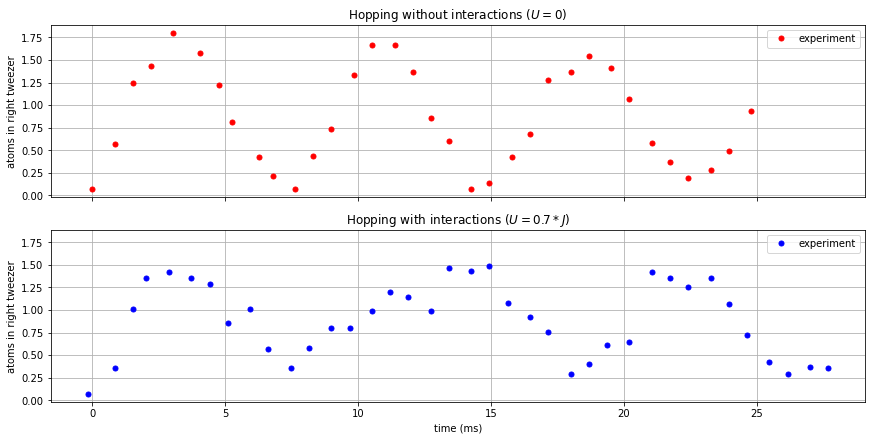

In [4]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True,figsize=(12,6),constrained_layout=True)
ax1.plot(no_int_time, no_int_nR, "ro", label="experiment", markersize=5)
ax2.plot(with_int_time, with_int_nR, "bo", label="experiment", markersize=5)
ax1.set_ylabel(r"atoms in right tweezer")
ax2.set_ylabel(r"atoms in right tweezer")
ax2.set_xlabel(r"time (ms)")
ax1.set_title(r"Hopping without interactions ($U=0$)")
ax2.set_title(r"Hopping with interactions ($U=0.7*J$)")
ax1.legend()
ax2.legend();
ax1.grid();
ax2.grid();

## Analytical prediction

The Fermi-Hubbard hamiltonian preserves the total number of particles, the total number of spin up particles and the total number of spin down particles. Owing to these conserved quantities the hamiltonian takes a block diagonal form in the occupation number basis. These blocks represent various sectors which are not coupled by the hamiltonian.

For the current example we initialize the system in the sector $N=2,S_z=0$ (two atoms : one each for spin up and down). The dynamics of the system is limited to this subspace which is 4 dimensional. The Hamiltonian matrix in the subspace can be written down in the occupation number basis $\{LL, LR, RL, RR\}$ as:
$$
H = \left(\begin{array}{cccc}
U+2\Delta & -J & -J & 0\\
-J & 0 & 0 &-J\\
-J & 0 & 0 &-J\\
0 & -J & -J & U-2\Delta
            \end{array}
            \right)
$$ 

where $L$ and $R$ denote the left and right tweezer respectively. Here we consider the case for $\Delta = 0$, so the Hamiltonian matrix reads:

$$
H = \left(\begin{array}{cccc}
U & -J & -J & 0\\
-J & 0 & 0 &-J\\
-J & 0 & 0 &-J\\
0 & -J & -J & U
            \end{array}
            \right)
$$

We start out in the basis state $|LL\rangle$ (both atoms in the left tweezer) and we want to calculate how the atom number in the right tweezer evolves with time. We also consider two cases : $U=0$ and $U=0.7*J$.

In [5]:
from scipy.sparse.linalg import expm

In [6]:
J = np.pi * 134 # in units of hbar
U = 0.7 * J;

In [7]:
Nt_an = 50
t_analytical = np.linspace(0, 25, Nt_an) * 1e-3
H_With_Int = np.array([[U, -J, -J, 0], [-J, 0, 0, -J], [-J, 0, 0, -J], [0, -J, -J, U]])
H_Wo_Int = np.array([[0, -J, -J, 0], [-J, 0, 0, -J], [-J, 0, 0, -J], [0, -J, -J, 0]])

In [8]:
psi0 = np.zeros(4) * 1j
psi0[0] = 1.0 + 0j
print(psi0)

[1.+0.j 0.+0.j 0.+0.j 0.+0.j]


In [9]:
psis_wo_int = 1j * np.zeros((4, Nt_an))
psis_w_int = 1j * np.zeros((4, Nt_an))

for ii in np.arange(Nt_an):

    U_wo = expm(-1j * t_analytical[ii] * H_Wo_Int)
    psis_wo_int[:, ii] = np.dot(U_wo, psi0)

    U_w = expm(-1j * t_analytical[ii] * H_With_Int)
    psis_w_int[:, ii] = np.dot(U_w, psi0)

ps_wo = np.abs(psis_wo_int) ** 2
ps_w = np.abs(psis_w_int) ** 2

In [10]:
nR_wo = ps_wo[1, :] + ps_wo[2, :] + 2 * ps_wo[3, :]
nR_w = ps_w[1, :] + ps_w[2, :] + 2 * ps_w[3, :];

#### Compare to the experimental data.

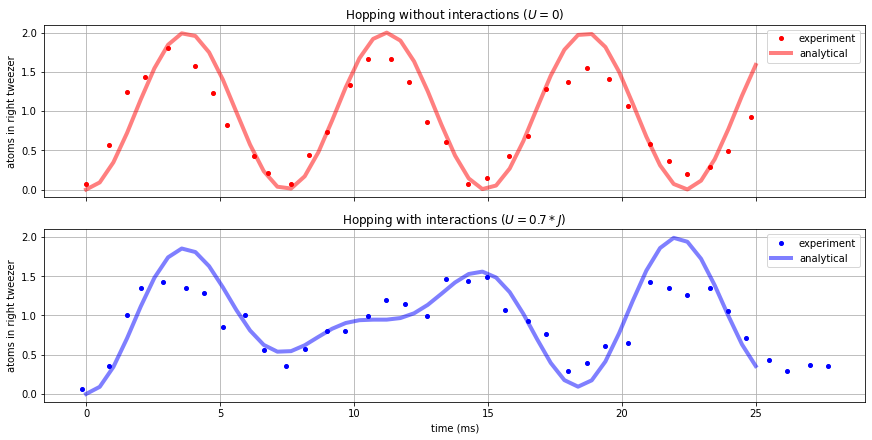

In [11]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True,figsize=(12,6),constrained_layout=True)

ax1.plot(no_int_time, no_int_nR, "ro", label="experiment", markersize=4)
ax1.plot(t_analytical * 1e3, nR_wo, "r-", label="analytical", linewidth=4, alpha=0.5)

ax2.plot(with_int_time, with_int_nR, "bo", label="experiment", markersize=4)
ax2.plot(t_analytical * 1e3, nR_w, "b-", label="analytical", linewidth=4, alpha=0.5)

ax1.set_ylabel(r"atoms in right tweezer")
ax2.set_ylabel(r"atoms in right tweezer")
ax2.set_xlabel(r"time (ms)")
#ax2.set_xlim(0, 20)
ax1.set_title(r"Hopping without interactions ($U=0$)")
ax2.set_title(r"Hopping with interactions ($U=0.7*J$)")
ax1.legend()
ax2.legend();
ax1.grid();
ax2.grid();

## Simulation with `qiskt-cold-atom`.

See the [third tutorial](./03_fermionic_tweezer_hardware.ipynb) for examples on writing fermion circuits using `qiskt-cold-atom`.

In [12]:
from qiskit_cold_atom.providers import ColdAtomProvider
from qiskit_cold_atom.fermions.fermion_gate_library import FermiHubbard

provider = ColdAtomProvider()
backend = provider.get_backend("fermionic_tweezer_simulator")

In [13]:
def get_left_right_occupation(counts):
    sum_counts = 0
    nL = 0
    nR = 0
    for k, v in counts.items():
        # look for lefties
        sum_counts += v
        if int(k[0]):
            nL += v
        if int(k[4]):
            nL += v
        if int(k[1]):
            nR += v
        if int(k[5]):
            nR += v
    return nL / sum_counts, nR / sum_counts

#### Hopping without interactions ($U=0$)

In [14]:
Ntimes = 50
times = np.linspace(0, 25, Ntimes) * 1e-3
means = np.zeros(Ntimes)
for i in range(Ntimes):
    time = times[i]
    qc = backend.initialize_circuit([[1, 0, 0, 0], [1, 0, 0, 0]])
    all_modes = range(8)

    qc.append(
        FermiHubbard(
            num_modes=8, j=[J * time, 0, 0], u=0 * time, mu=[0 * time, 0, 0, 0]
        ),
        qargs=all_modes,
    )
    qc.measure_all()
    job = backend.run(qc, shots=100)
    counts = job.result().get_counts()
    _, means[i] = get_left_right_occupation(counts)

c:\users\rohit_prasad_bhatt\documents\github\qiskit-cold-atom\qiskit_cold_atom\fermions\fermion_gate_library.py:325: UserWarning: The default value for `display_format` will be changed from 'dense' to 'sparse' in version 0.3.0. Once that happens, you must specify display_format='dense' directly.
  return FermionicOp("I_0", register_length=self.num_modes)


#### Hopping with interactions ($U=0.7*J$)

In [15]:
Ntimes = 50
times = np.linspace(0, 25, Ntimes) * 1e-3
means_int = np.zeros(Ntimes)
for i in range(Ntimes):
    time = times[i]
    qc = backend.initialize_circuit([[1, 0, 0, 0], [1, 0, 0, 0]])
    all_modes = range(8)

    qc.append(
        FermiHubbard(
            num_modes=8, j=[J * time, 0, 0], u=U * time, mu=[0 * time, 0, 0, 0]
        ),
        qargs=all_modes,
    )
    qc.measure_all()
    job = backend.run(qc, shots=100)
    counts = job.result().get_counts()
    _, means_int[i] = get_left_right_occupation(counts)

#### Compare to the experimental data.

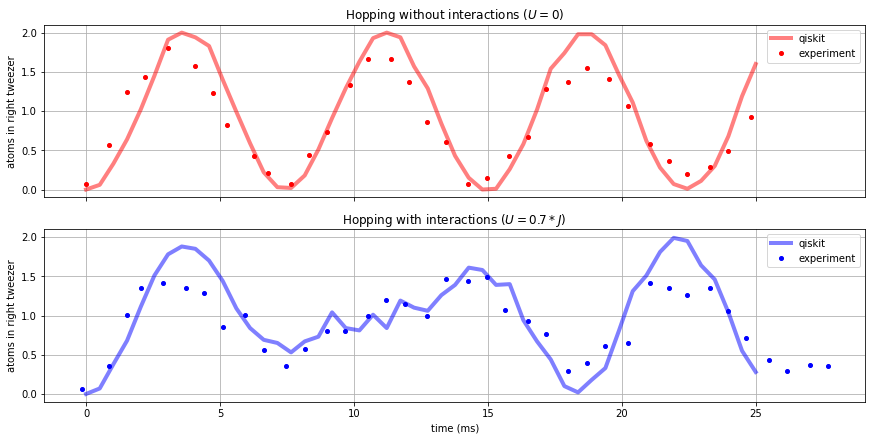

In [16]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True,figsize=(12,6),constrained_layout=True)


ax1.plot(times * 1e3, means, "r-", label="qiskit", linewidth=4, alpha=0.5)
#ax1.plot(t_analytical * 1e3, nR_wo, "r-.", label="analytical", linewidth=4, alpha=0.5)
ax1.plot(no_int_time, no_int_nR, "ro", label="experiment", markersize=4)

ax2.plot(times * 1e3, means_int, "b-", label="qiskit", linewidth=4, alpha=0.5)
#ax2.plot(t_analytical * 1e3, nR_w, "b-.", label="analytical", linewidth=4, alpha=0.5)
ax2.plot(with_int_time, with_int_nR, "bo", label="experiment", markersize=4)
ax1.set_ylabel(r"atoms in right tweezer")
ax2.set_ylabel(r"atoms in right tweezer")
ax2.set_xlabel(r"time (ms)")
ax1.legend(loc="upper right")
ax2.legend(loc="upper right")
#ax1.set_xlim(-1, 20)
ax1.set_title(r"Hopping without interactions ($U=0$)")
ax2.set_title(r"Hopping with interactions ($U=0.7*J$)")
ax1.grid();
ax2.grid();

# Optional: Working on a cloud simulator

We would also like to send such circuits to some real hardware and investigate these results. In this last section, we will present this possibility with the [synqs provider](https://qsimsim.synqs.org) . 


<div class="alert alert-block alert-info">
<b>Note:</b> To run the cells in this part of the tutorial that interface with a remote device backend, you'll need to have a registered account with a valid username and password for this provider which can be obtained at the URL linked above.</div>

In a first step, it is necessary to import the cold atom provider.

In [17]:
from qiskit_cold_atom.providers import ColdAtomProvider
from qiskit.circuit import QuantumCircuit, Parameter

from pprint import pprint

In [18]:
provider = ColdAtomProvider.load_account(R'C:\Users\Rohit_Prasad_Bhatt\.qiskit\cold_atom_credentials.conf')

fermion_device_backend = provider.get_backend("synqs_fermionic_tweezer_simulator")
pprint(fermion_device_backend.configuration().supported_instructions)

['load', 'measure', 'barrier', 'hop', 'int', 'phase']


#### Caution: synqs backend uses interleaved notation. Discuss this with others. We could write a coverting function between the two approaches. The function could accept a boolean flag which tells whether the backend uses interleaved notation or not.

## No interaction
In a first set of experiments there are no interactions and the two atoms are simply allowed to hop. The experiment is then described by the following very simple circuit.

now let us simulate the time evolution

In [19]:
theta_j = Parameter("theta_j")

In [20]:
# the parameters of the experiment
J = np.pi * 134
Ntimes = 15
times = np.linspace(0, 20, Ntimes) * 1e-3
theta_js = -1 * J * times
means = np.zeros(Ntimes)

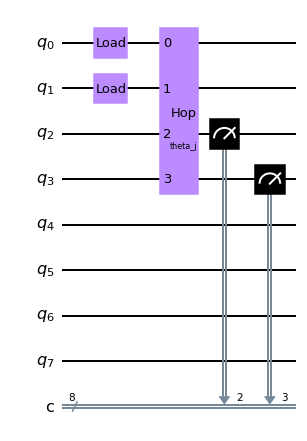

In [21]:
circuit1 = QuantumCircuit(8,8)
circuit1.load_fermions(0)
circuit1.load_fermions(1)
circuit1.hop_fermions([theta_j],list(range(0,4)))
circuit1.measure(2,2)
circuit1.measure(3,3)
circuit1.draw(output='mpl')

In [22]:
circuit1_list = [circuit1.bind_parameters({theta_j: theta%(2*np.pi)}) for theta in theta_js]

In [23]:
job1 = fermion_device_backend.run(circuit1_list, shots = 500)

In [24]:
job1.job_id()

'20211202_103222-fermions-synqs_test-c0eba'

In [25]:
job_retrieved1 = fermion_device_backend.retrieve_job(job_id = job1.job_id())

print("job status: ", job_retrieved1.status())

job status:  JobStatus.INITIALIZING


In [26]:
result1 = job_retrieved1.result()

In [27]:
outcomes1 = [result1.get_memory(i) for i in range(len(circuit1_list))]

In [28]:
for i in range(Ntimes):
    means[i] = np.array(list(map(str.split,outcomes1[i]))).astype('int').sum(axis=1).mean()

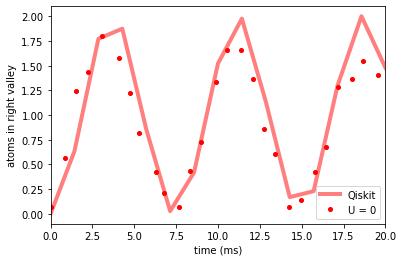

In [29]:
f, ax1 = plt.subplots(1, 1, sharex=True, sharey=True)
ax1.plot(times * 1e3, means, "r-", label="Qiskit", linewidth=4, alpha=0.5)
ax1.plot(
    no_int_time, no_int_nR, "ro", label="U = 0", markersize=4
)
ax1.set_ylabel(r"atoms in right valley")
ax1.set_xlabel(r"time (ms)")
ax1.legend()
ax1.set_xlim(0, 20);

## Hopping with interactions

In a next step the atoms are interacting. The circuit description of the experiment is the application of the hopping gate and the interaction gate. It can be written as

As you can see the back-end is only implementation a limited set of back-ends such that the full circuit has to be trotterized.

In [30]:
theta_j = Parameter("theta_j")
theta_u = Parameter("theta_u")

# the parameters of the experiment
J = np.pi * 134
U = 0.7 * J
Ntimes = 15
times = np.linspace(0, 20, Ntimes) * 1e-3
theta_js = -1 * J * times
theta_us = U * times
means_int = np.zeros(Ntimes)
Ntrott = 15

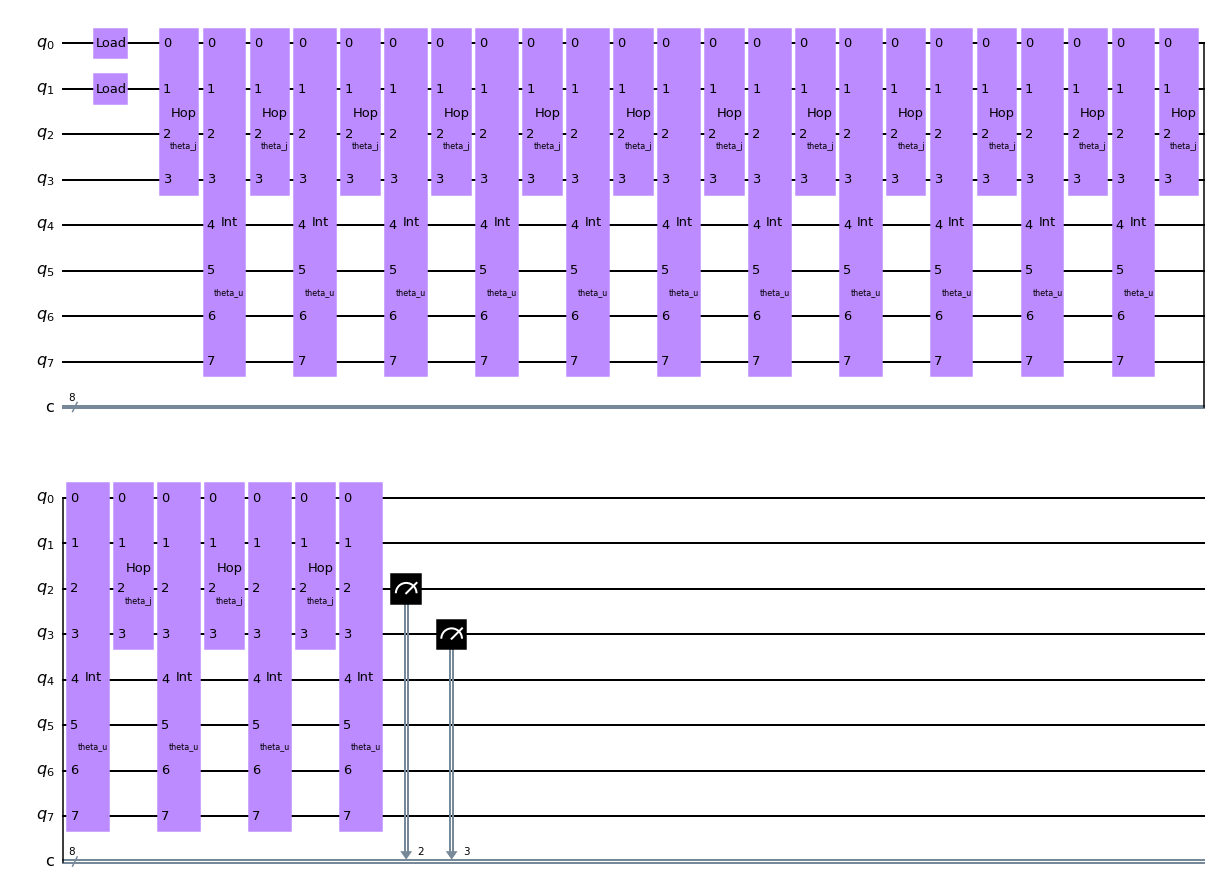

In [31]:
circuit2 = QuantumCircuit(8, 8)
circuit2.load_fermions(0)
circuit2.load_fermions(1)
for ii in range(Ntrott):
    circuit2.hop_fermions([theta_j], list(range(0, 4)))
    circuit2.int_fermions(theta_u, list(range(0, 8)))
circuit2.measure(2, 2)
circuit2.measure(3, 3)
circuit2.draw(output="mpl")

next we set up the circuits that calculate each time step and send it to the back-end

In [32]:
circuit2_list = [
    circuit2.bind_parameters(
        {
            theta_j: (theta1 / Ntrott) % (2 * np.pi),
            theta_u: (theta2 / Ntrott) % (2 * np.pi),
        }
    )
    for (theta1, theta2) in zip(theta_js, theta_us)
]
job2 = fermion_device_backend.run(circuit2_list, shots=500)

You will now have to save the job and wait und the job status has changed to done. 

In [33]:
pprint(job2.job_id())

'20211202_103257-fermions-synqs_test-27f3a'


In [34]:
job_retrieved2 = fermion_device_backend.retrieve_job(job_id=job2.job_id())
print("job status: ", job_retrieved2.status())

job status:  JobStatus.INITIALIZING


Once the job is done, we can obtain once again the usual result, which was saved on the back-end, before we change it such that it can compared to the experimental data.

(0.0, 20.0)

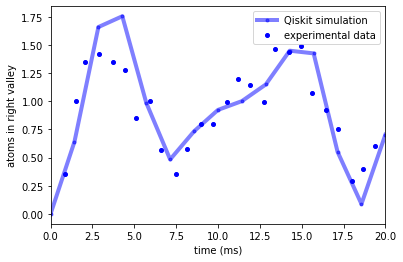

In [35]:
result2 = job_retrieved2.result()
outcomes2 = [result2.get_memory(i) for i in range(len(circuit2_list))]
for i in range(Ntimes):
    means_int[i] = (
        np.array(list(map(str.split, outcomes2[i]))).astype("int").sum(axis=1).mean()
    )


f, ax2 = plt.subplots(1, 1, sharex=True, sharey=True)

ax2.plot(
    times * 1e3, means_int, "b.-", label="Qiskit simulation", linewidth=4, alpha=0.5
)
ax2.plot(
    with_int_time,
    with_int_nR,
    "bo",
    label="experimental data",
    markersize=4,
)
ax2.set_ylabel(r"atoms in right valley")
ax2.set_xlabel(r"time (ms)")
ax2.legend()
ax2.set_xlim(0, 20)

## References

[1] [Simon Murmann et al.](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.114.080402) *Two Fermions in a Double Well: Exploring a Fundamental Building Block of the Hubbard Model*. Phys. Rev. Lett. 114, 080402 (2015).

In [36]:
import qiskit.tools.jupyter

%qiskit_version_table

C:\Users\Rohit_Prasad_Bhatt\miniconda3\envs\py385\lib\site-packages\qiskit\aqua\operators\operator_globals.py:46: DeprecationWarning: `from_label` is deprecated and will be removed no earlier than 3 months after the release date. Use Pauli(label) instead.
  X = make_immutable(PrimitiveOp(Pauli.from_label('X')))
